## Activation Energy and Pre-exponential Factors

Necessary imports

In [72]:
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit
import scipy.io
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

### Linear Regression function for linearized Arrhenius equation

In [73]:
# Linearize Arrhenius eq and fit regression
def linear_fit_Ea_and_lnA(inverse_temperatures, rate_constants, R_constant):

    # Input to -1/RT
    x =- inverse_temperatures/R_constant
    
    # Take the natural log of the rate constants
    ln_k = np.log(rate_constants)

    # Perform linear regression on ln(k) vs 1/T
    Ea, lnA, _, _, Ea_se = linregress(x, ln_k)

    lnA_se = Ea_se * np.sqrt(1/N + np.mean(x)**2 / np.sum((x - np.mean(x))**2))


    return [Ea, lnA, Ea_se, lnA_se]


### Nonlinear Regression function for Arrhenius equation

In [74]:
# Arrhenius function to fit
def arrhenius_eq(T, A, Ea):
    return A * np.exp(-Ea / (R_constant * T))

Data and constants

In [75]:
# Input temperatures
temperatures = np.array([450., 460., 470., 475., 480., 490.])
# Inverse temperature as input for LR
inverse_temperatures = 1/temperatures
# Number of temperatures
N = len(temperatures)
# Ideal gas constant in kcal/(mol·K)
R_constant = 0.001987204258 
# for plotting
labels = ['Adsorption R1', 'Adsorption R2', 'Desorption R23','Desorption R14']

In [76]:
# Results from Pyomo
k_pyomo = scipy.io.loadmat('k_pyomo.mat')
k_pyomo = k_pyomo['k']


In [77]:
# Results from pMCMC
k_pmcmc = scipy.io.loadmat('k_pmcmc.mat')
# k1_ads_pmcmc = k_pmcmc['k1_ads']
# k2_ads_pmcmc = k_pmcmc['k2_ads']
# k3_des_pmcmc = k_pmcmc['k3_des']
# k4_des_pmcmc = k_pmcmc['k4_des']
k_pmcmc = [k_pmcmc['k1_ads'],k_pmcmc['k2_ads'],k_pmcmc['k3_des'],k_pmcmc['k4_des'] ]

Linearized results PYOMO vs PMCMC

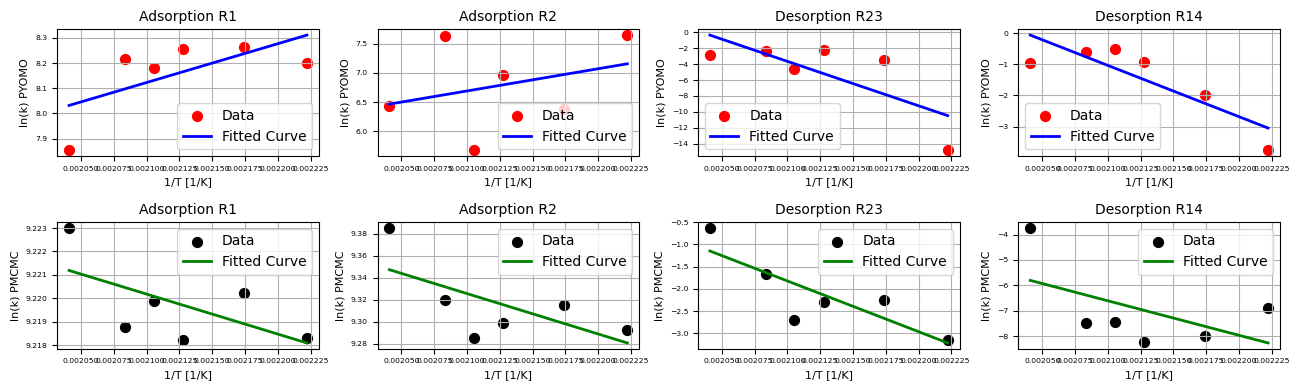

In [78]:
Ea = []
lnA = []
se = []
R = 4

# Create subplots: 2 rows, 2 columns (since R=4)
fig, axes = plt.subplots(2, 4, figsize=(13, 4))
axes = axes.flatten()   

# For
for r in range(R):
    rate_constants_pyomo = np.array(k_pyomo[r], dtype=float) 
    rate_constants_pmcmc = np.array(k_pmcmc[r], dtype=float) 
    Ea_pyomo, lnA_pyomo, stdEa_pyomo, stdlnA_pyomo = linear_fit_Ea_and_lnA(inverse_temperatures, rate_constants_pyomo, R_constant)
    Ea_pmcmc, lnA_pmcmc, stdEa_pmcmc, stdlnA_pmcmc = linear_fit_Ea_and_lnA(inverse_temperatures, rate_constants_pmcmc, R_constant)


    Ea.append([Ea_pyomo, Ea_pmcmc])
    lnA.append([lnA_pyomo, lnA_pmcmc])
    se.append([[stdEa_pyomo, stdlnA_pyomo], [stdEa_pmcmc, stdlnA_pmcmc]])

    # Optional: plot the results
    T_fit = np.linspace(min(temperatures), max(temperatures), 100)
    lnk_fit_pyomo = - Ea_pyomo/(T_fit*R_constant) + lnA_pyomo
    lnk_fit_pmcmc = - Ea_pmcmc/(T_fit*R_constant) + lnA_pmcmc


    # Plot in corresponding subplot
    ax1 = axes[r]
    ax1.scatter(inverse_temperatures, np.log(rate_constants_pyomo), color='red', label='Data', s=50)  # Data points
    ax1.plot(1/T_fit, lnk_fit_pyomo, color='blue', linewidth=2, label='Fitted Curve')  # Fitted curve
    ax1.set_xlabel('1/T [1/K]', fontsize=8)
    ax1.set_ylabel('ln(k) PYOMO', fontsize=8)
    ax1.set_title(labels[r], fontsize=10)
    ax1.tick_params(axis='both', which='major', labelsize=5.5)
    ax1.legend()
    ax1.grid()

     # Plot in corresponding subplot
    ax2 = axes[4+r]
    ax2.scatter(inverse_temperatures, np.log(rate_constants_pmcmc), color='k', label='Data', s=50)  # Data points
    ax2.plot(1/T_fit, lnk_fit_pmcmc, color='green', linewidth=2, label='Fitted Curve')  # Fitted curve
    ax2.set_xlabel('1/T [1/K]', fontsize=8)
    ax2.set_ylabel('ln(k) PMCMC', fontsize=8)
    ax2.set_title(labels[r], fontsize=10)
    ax2.tick_params(axis='both', which='major', labelsize=5.5)
    ax2.legend()
    ax2.grid()

plt.subplots_adjust(hspace=0.1, wspace=0.55)  # Increase vertical (hspace) and horizontal (wspace) space
plt.tight_layout()


In [79]:
rate_constants_pmcmc


array([[0.00102878, 0.00034237, 0.00027088, 0.00057479, 0.00056644,
        0.02404509]])

## Nonlinear Regression Results

0
1
3


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

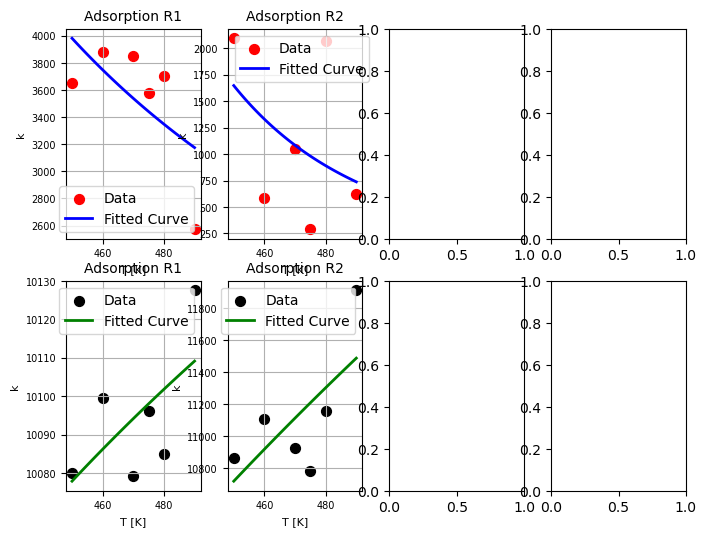

In [86]:
Ea_init_pyomo = [Ea[0][0],Ea[1][0],2,Ea[3][0]]
A_init_pyomo = [np.exp(lnA[0][0]), np.exp(lnA[1][0]), 0.05, np.exp(lnA[3][0])]

Ea_init_pmcmc = [Ea[0][1],Ea[1][1],Ea[2][1],Ea[3][1]]
A_init_pmcmc = [np.exp(lnA[0][1]), np.exp(lnA[1][1]), np.exp(lnA[2][1]), np.exp(lnA[3][1])]

Ea_nl = []
A_nl = []
se_nl = []

# Create subplots: 2 rows, 2 columns (since R=4)
fig, axes = plt.subplots(2, 4, figsize=(8, 6))
axes = axes.flatten()  

for r in range(R):

    if r !=2:

        # Initial guess for [A, Ea]
        init_pyomo = [A_init_pyomo[r], Ea_init_pyomo[r]]  # Example initial guess for A and Ea
        init_pmcmc = [A_init_pmcmc[r], Ea_init_pmcmc[r]]
        rate_constants_pyomo = np.array(k_pyomo[r], dtype=float)
        rate_constants_pmcmc = np.array(k_pmcmc[r], dtype=float)

        print(r)

        # Perform nonlinear regression
        params_pyomo, covariance_pyomo = curve_fit(arrhenius_eq, temperatures, rate_constants_pyomo, p0=init_pyomo)
        params_pmcmc, covariance_pmcmc = curve_fit(arrhenius_eq, temperatures, rate_constants_pmcmc[0], p0=init_pmcmc)

        # Extract fitted parameters
        A_fit_pyomo, Ea_fit_pyomo = params_pyomo
        A_fit_pmcmc, Ea_fit_pmcmc = params_pmcmc

        Ea_nl.append([Ea_fit_pyomo, Ea_fit_pmcmc])
        A_nl.append([A_fit_pyomo, A_fit_pmcmc])

        # Calculate standard errors
        std_errors_pyomo = np.sqrt(np.diag(covariance_pyomo))
        std_errors_pmcmc = np.sqrt(np.diag(covariance_pmcmc))


        se_nl.append([std_errors_pyomo, std_errors_pmcmc])

        # Optional: plot the results
        T_fit = np.linspace(min(temperatures), max(temperatures), 100)
        k_fit_pyomo = arrhenius_eq(T_fit, *params_pyomo)
        k_fit_pmcmc = arrhenius_eq(T_fit, *params_pmcmc)

        # Plot in corresponding subplot
        ax = axes[r]
        ax.scatter(temperatures, rate_constants_pyomo, color='red', label='Data', s=50)  # Data points
        ax.plot(T_fit, k_fit_pyomo, color='blue', linewidth=2, label='Fitted Curve')  # Fitted curve
        ax.set_xlabel('T [K]', fontsize=8)
        ax.set_ylabel('k', fontsize=8)
        ax.set_title(labels[r], fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.legend()
        ax.grid()

            # Plot in corresponding subplot
        ax = axes[r+4]
        ax.scatter(temperatures, rate_constants_pmcmc, color='k', label='Data', s=50)  # Data points
        ax.plot(T_fit, k_fit_pmcmc, color='green', linewidth=2, label='Fitted Curve')  # Fitted curve
        ax.set_xlabel('T [K]', fontsize=8)
        ax.set_ylabel('k', fontsize=8)
        ax.set_title(labels[r], fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.legend()
        ax.grid()

plt.subplots_adjust(hspace=0.1, wspace=0.55)  # Increase vertical (hspace) and horizontal (wspace) space
plt.tight_layout()